In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import qexpy as q
import qexpy.plotting as qplt
import pandas as pd

In [23]:
def malus(x,a,b):
    return a* q.cos(x*b)**2
def cos2(x):
    return q.cos(x)**2

def read_images(path_filename,format,output_colour,Image_number):
    Flags = [cv2.IMREAD_COLOR, cv2.IMREAD_GRAYSCALE, cv2.IMREAD_UNCHANGED ]
    if str(output_colour) == "color":
        i = 0
        print("Imagenes convertidas con éxito a color")
    elif str(output_colour) == "grises":
        i = 1
        print("Imagenes convertidas con éxito a escala de grises")
    elif str(output_colour) == "sin_cambios":
        i = 2
        print("Imagenes convertidas con éxito al formato inicial")
    else:
        i = 0
        print("Imagenes convertidas por default con éxito a escala de grises")
      
    flag = Flags[i]
    I_XY = []
    for i in range(Image_number):
        filename = str(path_filename)+str(i+1)+str('.')+str(format)
        I_XY.append(cv2.imread(filename, flag))  
    return I_XY

def print_images(image_matrix_list, output_colour, number_of_images):

    if str(output_colour) == "color":
        print("Las imagenes se imprimen en color RGB")

        image_matrix_list_RGB = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in image_matrix_list]
        for i in range(number_of_images):
            plt.imshow(image_matrix_list[i])
            plt.colorbar()
            plt.show()  
    elif str(output_colour) == "grises":
        print("Las imagenes se imprimen en escala de grises")

        for i in range(number_of_images):
            plt.imshow(image_matrix_list[i], cmap='gray', vmin=0, vmax=255)
            plt.colorbar()
            plt.show()   
    elif str(output_colour) == "binary":
        print("Las imagenes se imprimen en binario")
        for i in range(number_of_images):
            plt.imshow(image_matrix_list[i], cmap='gray', vmin=0, vmax=1)
            plt.colorbar()
            plt.show()  


    else:
        print("Las imagenes se imprimen por default en escala de grises")
        for i in range(number_of_images):
            plt.imshow(image_matrix_list[i], cmap='gray', vmin=0, vmax=255)
            plt.colorbar()
            plt.show()


def print_split_channels(I_XY_color):
    I_XY_color_B = [I_XY_color[i][:,:,0] for i in range(len(I_XY_color))]
    I_XY_color_G = [I_XY_color[i][:,:,1] for i in range(len(I_XY_color))]
    I_XY_color_R = [I_XY_color[i][:,:,2] for i in range(len(I_XY_color))]



def binarization(Matrix):
    a,b = np.shape(Matrix)
    Matrix_binary = np.zeros((a,b))
    cut = np.max(Matrix)/2
    for i in range(a):
        for j in range(b):
            if (Matrix[i,j]>= cut):
                Matrix_binary[i,j] = 1
    return Matrix_binary

def int_promedio(Matriz,radio):
    if radio==0:
        return Matriz
    else:
        a,b = np.shape(Matriz)
        Int_prom= np.zeros((a-2*radio,b-2*radio))
        for i in range(a-2*radio):
            for j in range(b-2*radio):
                Aux = Matriz[i:i+2*radio, j:j+2*radio]
                prom = Aux.mean()
                Int_prom[i,j]=round(prom)
        return Int_prom


def common_area_binary(list_matrices,N):
    list_matrices_binary = [binarization(Matrix) for Matrix in list_matrices[:int(N/6)]]
    Product = np.ones(np.shape(list_matrices[0]))
    for i in range(int(N/6)):
        Product_old = Product
        Product_new = np.multiply(Product_old,list_matrices_binary[i])
        Product = Product_new
    plt.imshow(Product_new, cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.show()
    
    return Product_new


def Intensidad_en_puntos(Matriz,Nx,Ny,radio):
    I = []
    Matriz_promedio = int_promedio(Matriz,radio)
    a,b = np.shape(Matriz_promedio)    
    for i in range(Ny):
        for j in range(Nx):
            x = int((b)/(2*Nx)*(2*j+1)) 
            y = int((a)/(2*Ny)*(2*i+1)) 
            I.append(Matriz_promedio[y,x])
    return I

def Intensidad_puntos_listas_radio(lista_Matriz,radio,Nx,Ny,N_imagenes):
    Intensidades_imagenes_por_punto = []
    for i in range(N_imagenes):
        Intensidades_imagenes_por_punto.append(Intensidad_en_puntos(lista_Matriz[i],Nx,Ny,radio))
    print("el formato es de  %d filas por %d columnas: una fila por ángulo, una columna por punto, para el radio de %d" % ( N_imagenes,Nx*Ny,radio))
    return np.array(Intensidades_imagenes_por_punto,int)

def Intensidad_media(lista_Matriz,radio,Nx,Ny,N_imagenes):
    Intensidades_promedio= []
    for i in range(N_imagenes):
        Intensidades_imagen = np.array(Intensidad_en_puntos(lista_Matriz[i],Nx,Ny,radio))
        Intensidad_promedio = np.mean(Intensidades_imagen)
        Intensidades_promedio.append(Intensidad_promedio)
    print("Se muestra la intensidad promediada en los %d puntos para cada uno de los %d ángulos" % (Nx*Ny, N_imagenes-1))
    return np.array(Intensidades_promedio,int)

    

def plot_intensidad_por_punto(I_XY_recortado,radio,Nx,Ny,N_fotos):
    Matriz_Ipp = Intensidad_puntos_listas_radio(I_XY_recortado,radio,Nx,Ny,N_fotos)
    I_0_2=Matriz_Ipp[0,:]
    angles, points = np.shape(Matriz_Ipp)
    theta = q.MeasurementArray( [np.radians(i*360./(angles-1)) for i in range(angles)],name= "Ángulo")
    for point in range(points):
        intensity_exp = q.MeasurementArray(Matriz_Ipp[:,point]*(1./I_0_2[point]),name = "Intensidad normalizada" % point)
        fig = qplt.plot(theta, intensity_exp,"--",label = "Datos Experimentales")
        result = q.fit(theta, intensity_exp, model = malus,parguess =[1,1])
        fig.plot(cos2,'--',label = 'Ley de Malus')
        title = 'Intensidad normalizada para el punto %d con radio = %d' % (point+1, radio)
        fig.title = title
        fig.legend()
        fig.plot(result)
        print(result)
        fig.show()




def plot_intensidad_promedio_por_radio(I_XY_recortado,lista_radios,Nx,Ny,N_fotos):
    for radio in lista_radios:
        Ipp_media = Intensidad_media(I_XY_recortado,radio,Nx,Ny,N_fotos)
        I_0_2=Ipp_media[0]
        angles = N_fotos
        theta = q.MeasurementArray( [np.radians(i*360./(angles-1)) for i in range(angles)],name= "Ángulo")
        intensity_exp = q.MeasurementArray(Ipp_media*(1./I_0_2),name = "Intensidad normalizada")
        fig = qplt.plot(theta, intensity_exp,"--",label = "Datos Experimentales")
        result = q.fit(theta, intensity_exp, model = malus,parguess =[1,1])
        fig.plot(cos2,'--',label = 'Ley de Malus')
        title = 'Intensidad media normalizada para radio = %d' %  radio
        fig.title = title
        fig.legend()
        fig.plot(result)
        print(result)
        fig.show()

def plot_media_polar_por_radio(I_XY_recortado,lista_radios,Nx,Ny,N_fotos):
    for radio in lista_radios:
        Ipp_media = Intensidad_media(I_XY_recortado,radio,Nx,Ny,N_fotos)
        I_0_2=Ipp_media[0]
        angles = N_fotos
        theta = [np.radians(i*360./(angles-1)) for i in range(angles)]
        intensity_exp = Ipp_media*(1./I_0_2)
        
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.plot(theta, intensity_exp,label = "Datos Experimentales")
    
        plt.plot(theta, np.cos(theta)**2,'--',label = 'Ley de Malus')
        title = 'Intensidad normalizada media para radio = %d' % radio
        ax.set_title(title)
        plt.legend()
        plt.show()

def plot_intensidad_por_punto_polar(I_XY_recortado,radio,Nx,Ny,N_fotos):
    Matriz_Ipp = Intensidad_puntos_listas_radio(I_XY_recortado,radio,Nx,Ny,N_fotos)
    I_0_2=Matriz_Ipp[0,:]
    angles, points = np.shape(Matriz_Ipp)
    theta = [np.radians(i*360./(angles-1)) for i in range(angles)]
    for point in range(points):
        intensity_exp = Matriz_Ipp[:,point]*(1./I_0_2[point])
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.plot(theta, intensity_exp,label = "Datos Experimentales")
    
        plt.plot(theta, np.cos(theta)**2,'--',label = 'Ley de Malus')
        title = 'Intensidad normalizada para el punto %d para radio = %d' % (point+1,radio)
        ax.set_title(title)
        plt.legend()
        plt.show()






In [4]:
I_XY = read_images('Images_ImageAnalysis/w','jpg','grises',37)

Imagenes convertidas con éxito a escala de grises


Las imagenes se imprimen en escala de grises


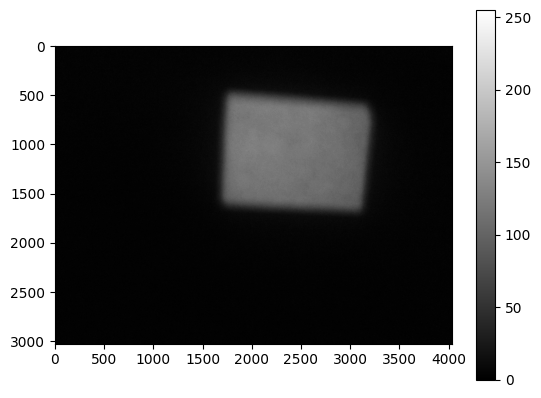

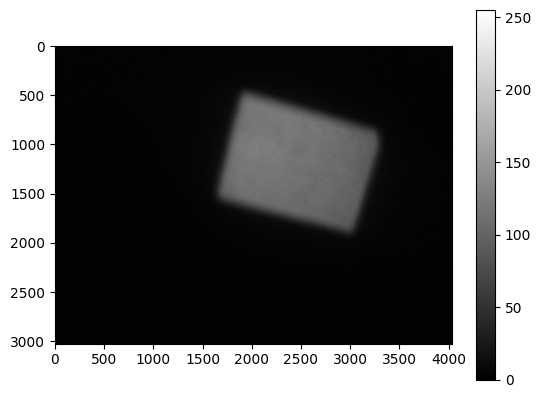

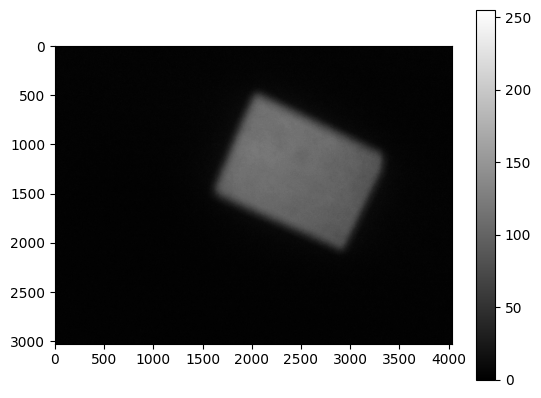

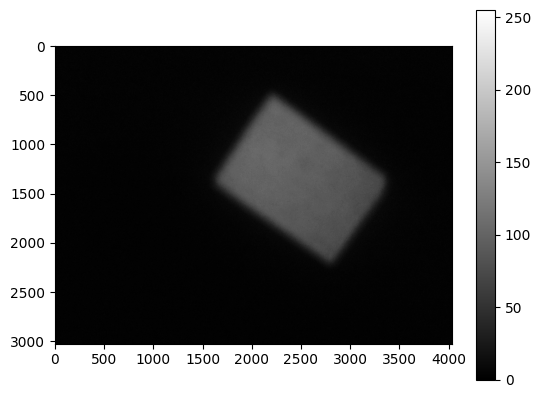

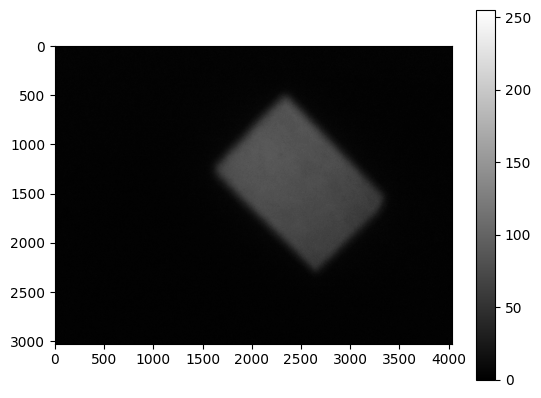

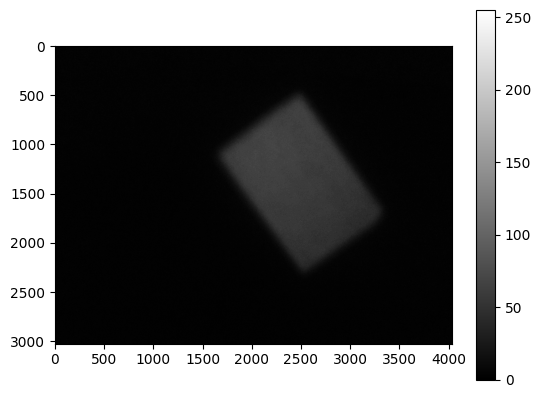

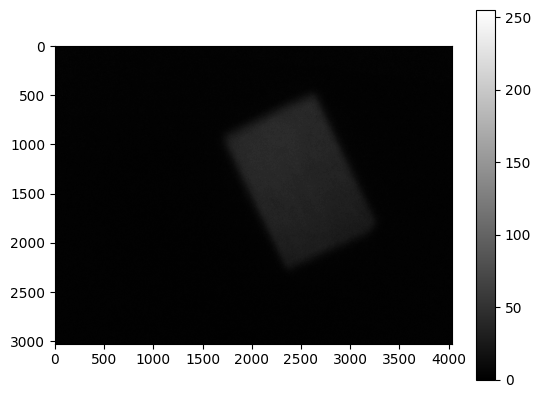

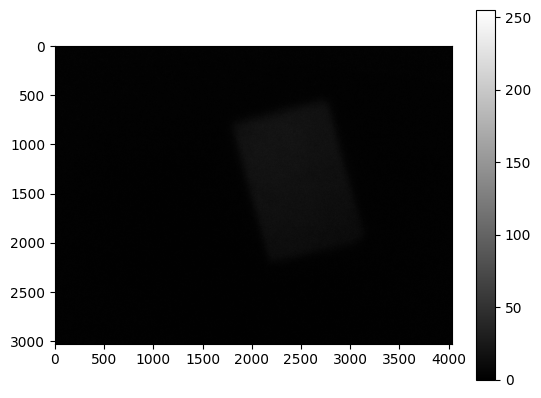

In [5]:
print_images(I_XY,'grises',8)

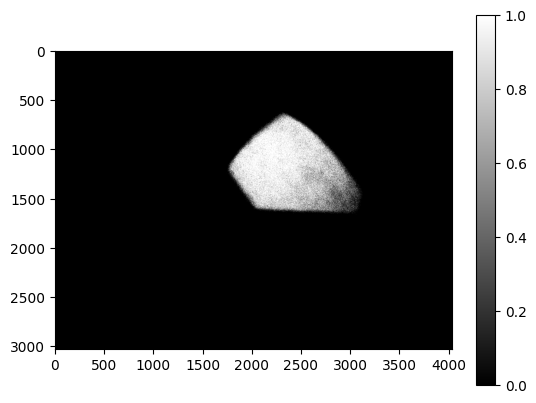

In [6]:
Common = common_area_binary(I_XY,36)


In [7]:
#recortar región de la imagen
#pixeles de inicio en la esquina superior izquierda en y vs x
Y_sup,X_sup = 1000 , 2200
#píxeles de final en la esquina derecha inferior
Y_inf,X_inf = 1200, 2300

I_XY_recortado=[I_XY[i][Y_sup:Y_inf,X_sup:X_inf] for i in range(len(I_XY))]



In [8]:
#16 puntos para verificar ley de malus
Nx, Ny = 2,8
radio, N_fotos = 3,37
Intensity = Intensidad_puntos_listas_radio(I_XY_recortado,radio,Nx,Ny,N_fotos)

el formato es de  37 filas por 16 columnas: una fila por ángulo, una columna por punto, para el radio de 3


In [9]:
angle = 0; point  = 15;
print(Intensity[0,:])
print(Intensity[:,0])
print(Intensity[angle,point])

[126 128 128 126 127 123 125 124 126 118 126 119 118 119 118 120]
[126 123 118 104  89  71  43  23   5   3   5  22  45  66  85  98 117 115
 130 117 110  98  80  60  39  14   3   2   5  19  41  64  83 100 111 116
 120]
120


el formato es de  37 filas por 16 columnas: una fila por ángulo, una columna por punto, para el radio de 3
----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.03 +/- 0.02,
b = 1.004 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.185]
 [-0.185  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


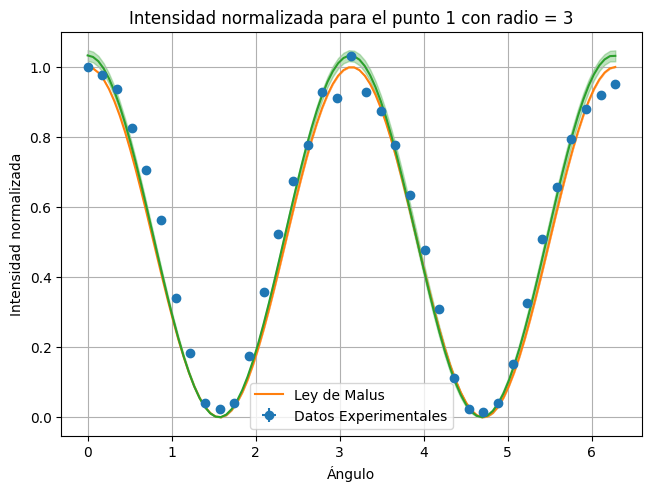

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.01 +/- 0.02,
b = 1.007 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.182]
 [-0.182  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


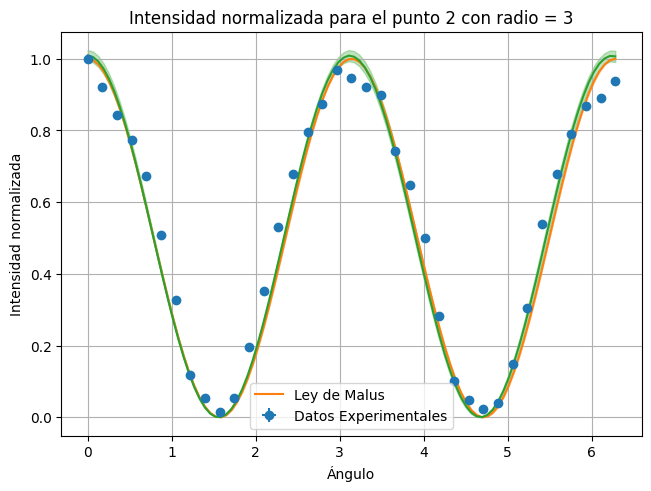

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.01 +/- 0.02,
b = 1.005 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.184]
 [-0.184  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


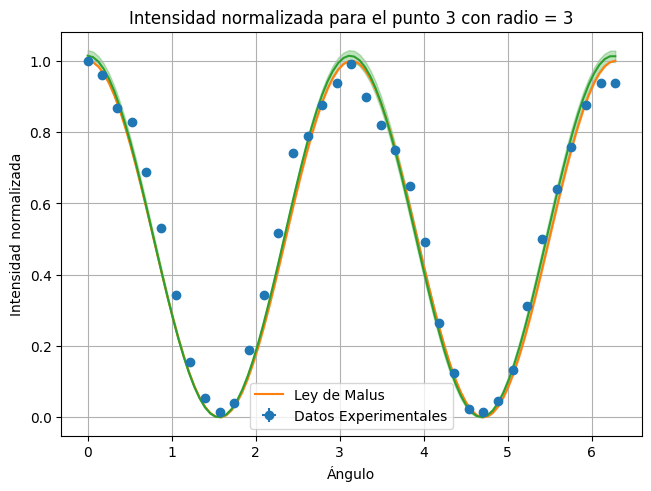

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.02 +/- 0.02,
b = 1.004 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.185]
 [-0.185  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


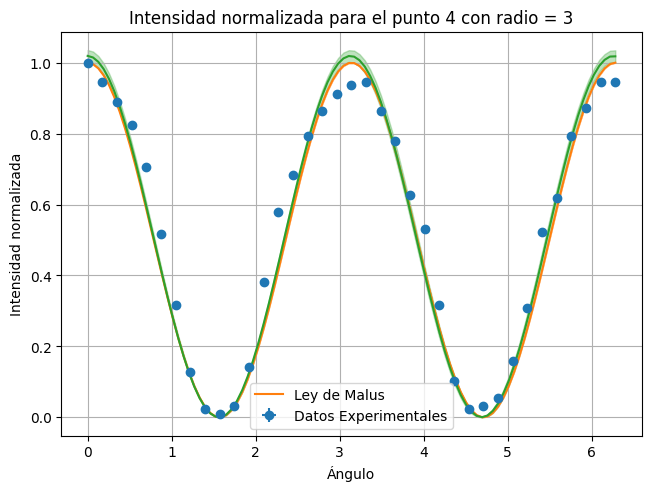

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.02 +/- 0.02,
b = 1.005 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.185]
 [-0.185  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


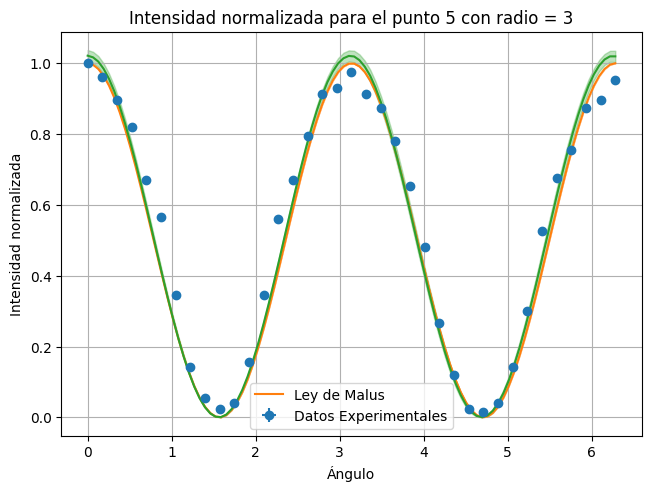

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.06 +/- 0.02,
b = 1.003 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.187]
 [-0.187  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


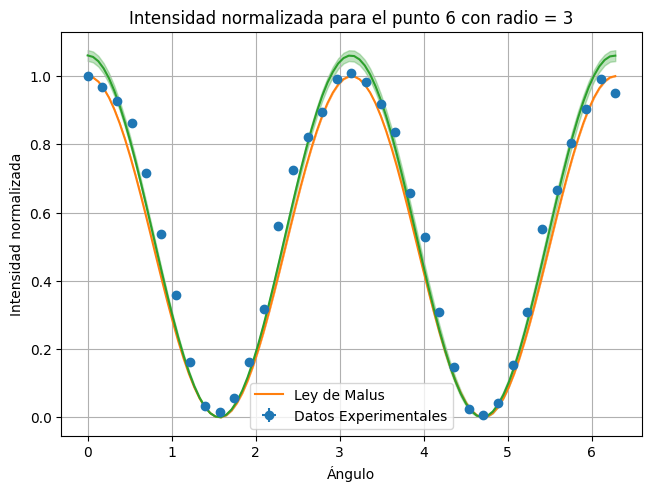

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.03 +/- 0.02,
b = 1.003 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.187]
 [-0.187  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


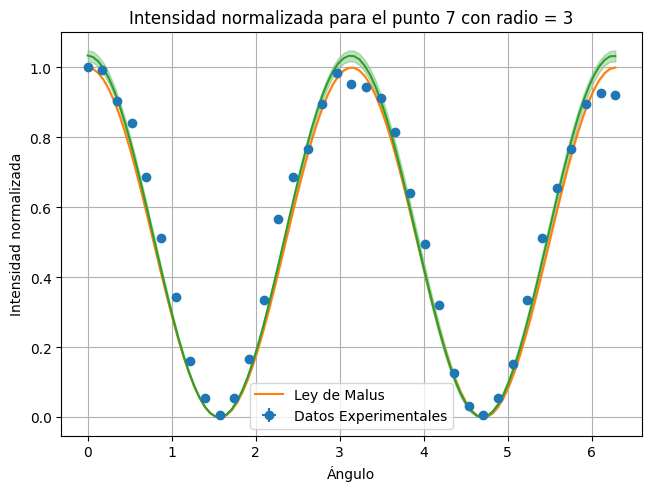

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.03 +/- 0.01,
b = 1.002 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.187]
 [-0.187  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


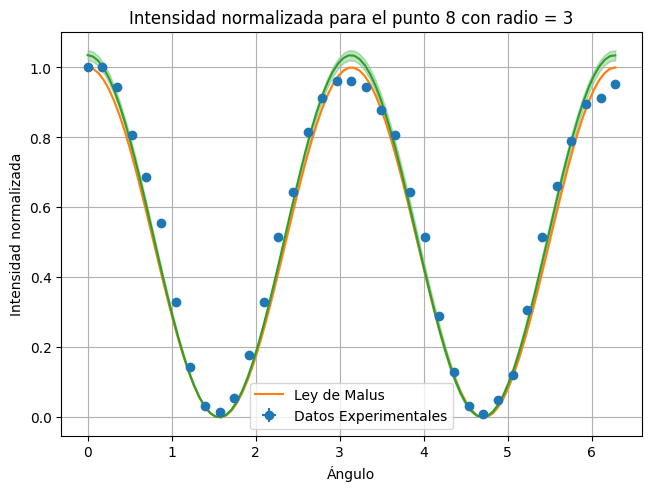

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.03 +/- 0.01,
b = 1.002 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.188]
 [-0.188  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


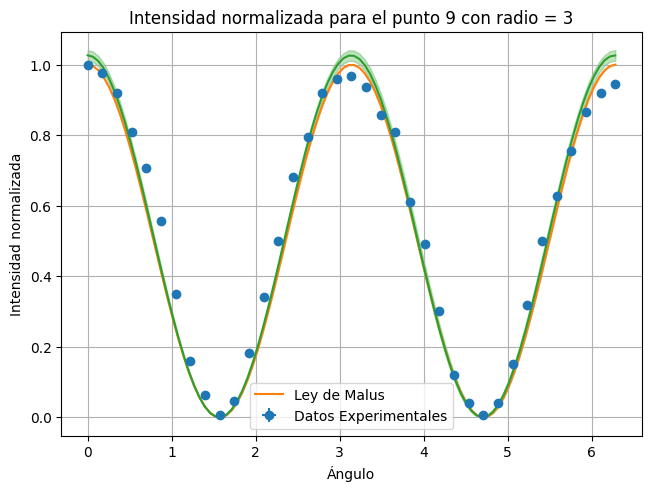

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.08 +/- 0.02,
b = 1.005 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.184]
 [-0.184  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


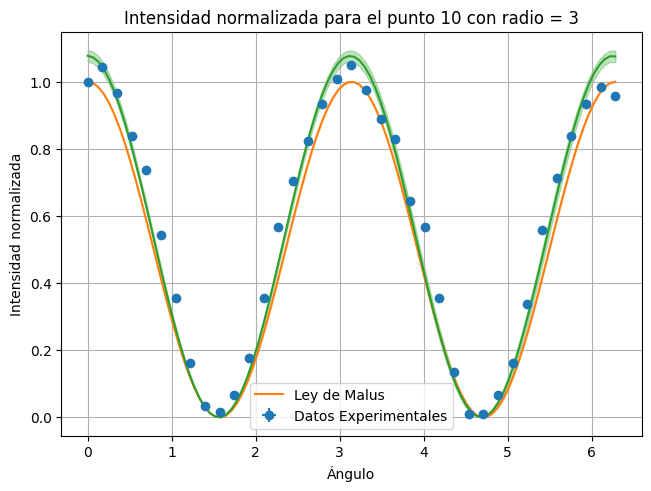

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.04 +/- 0.02,
b = 1.004 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.185]
 [-0.185  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


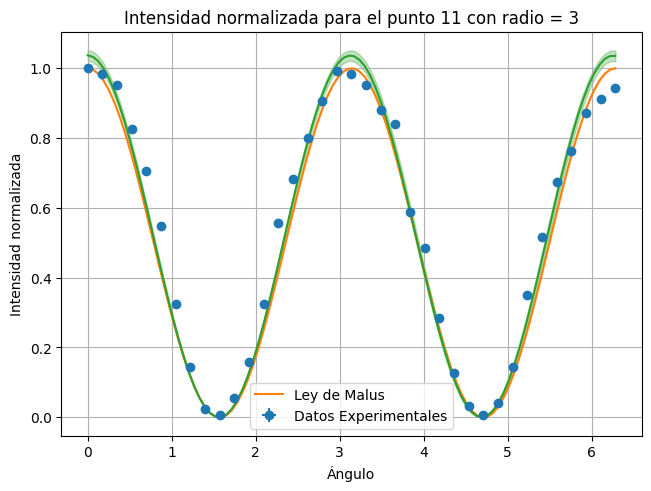

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.07 +/- 0.02,
b = 1.006 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.183]
 [-0.183  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


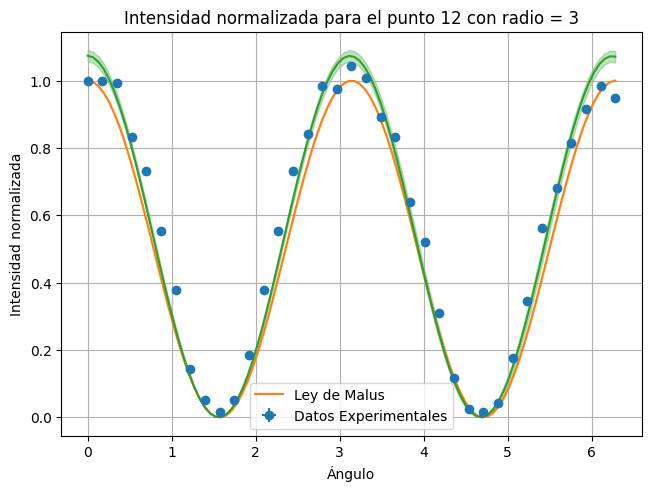

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.10 +/- 0.02,
b = 1.005 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.185]
 [-0.185  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


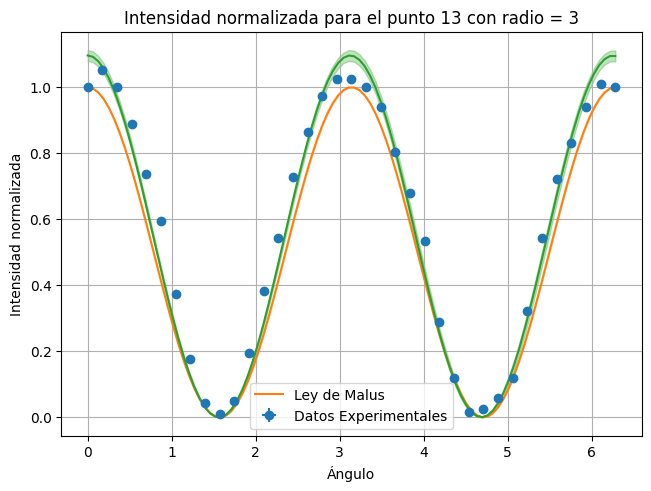

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.08 +/- 0.02,
b = 1.005 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.184]
 [-0.184  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


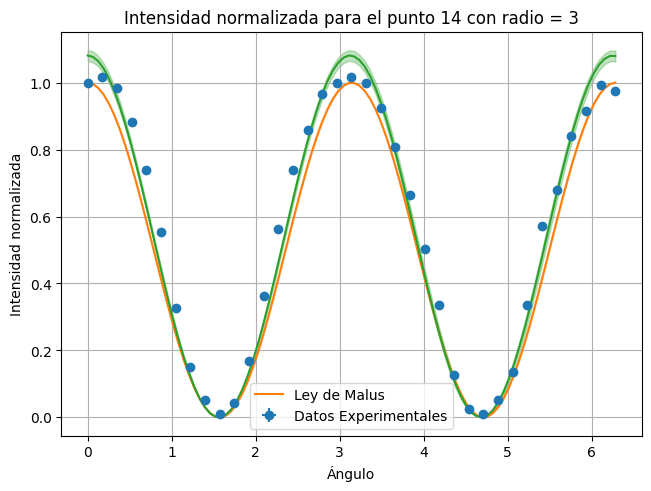

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.09 +/- 0.02,
b = 1.005 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.184]
 [-0.184  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


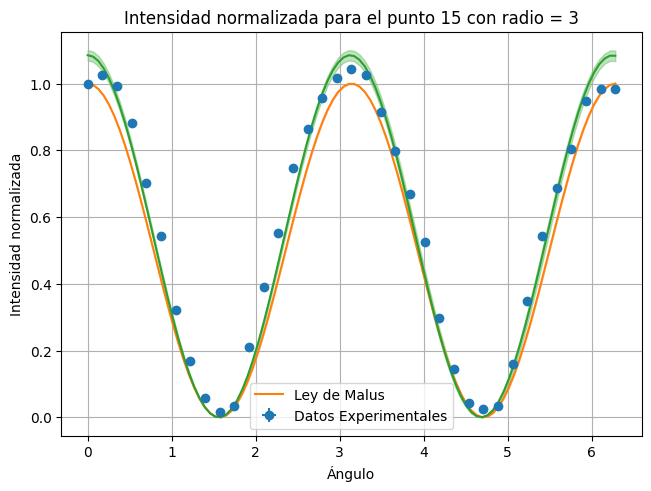

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.07 +/- 0.02,
b = 1.006 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.184]
 [-0.184  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


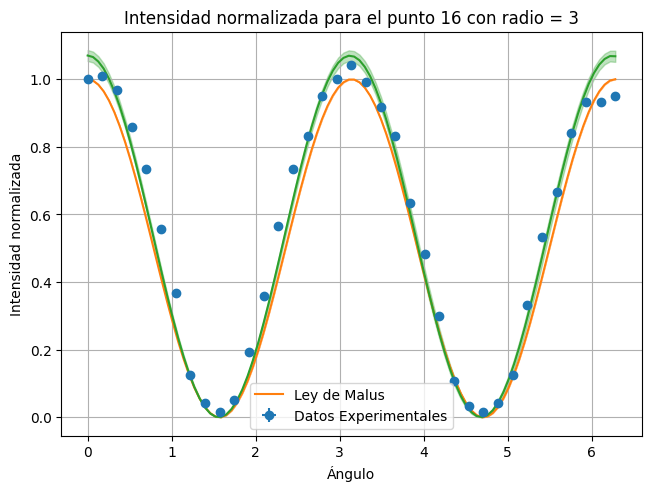

In [24]:
plot_intensidad_por_punto(I_XY_recortado,radio,Nx,Ny,N_fotos)

el formato es de  37 filas por 16 columnas: una fila por ángulo, una columna por punto, para el radio de 3


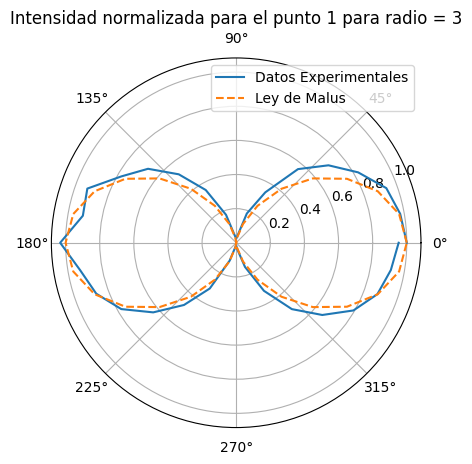

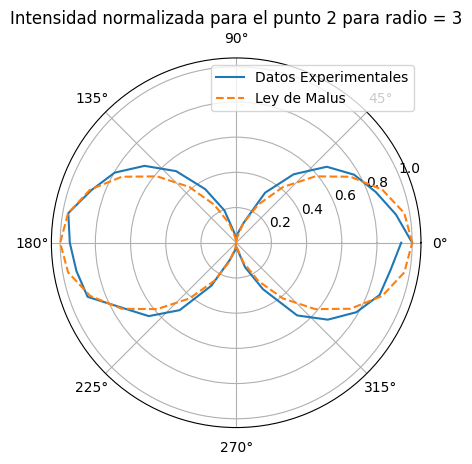

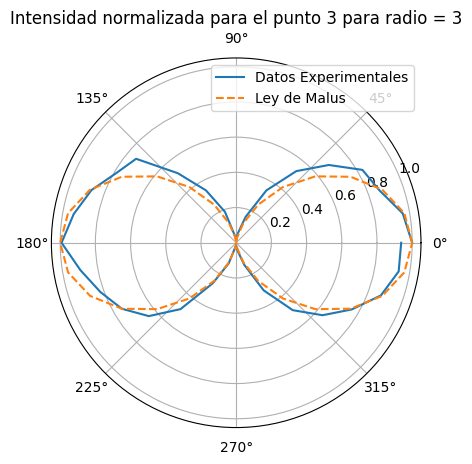

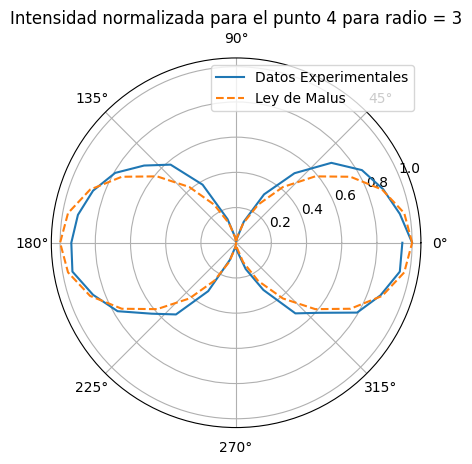

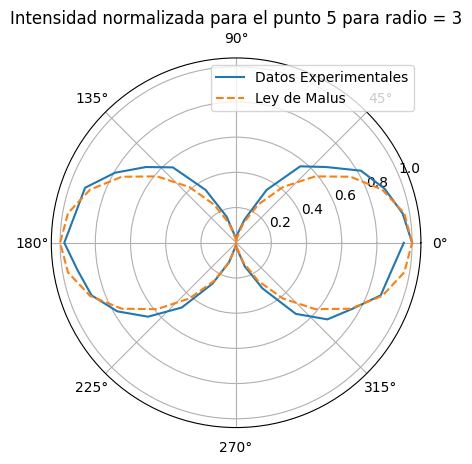

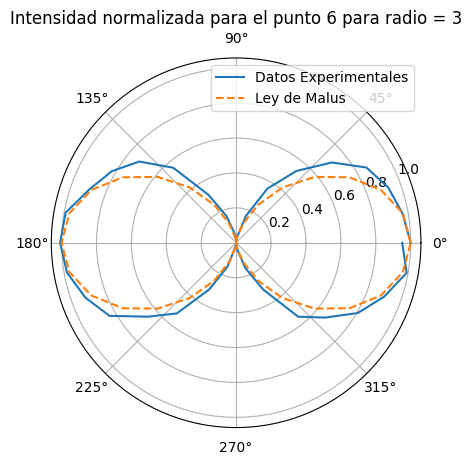

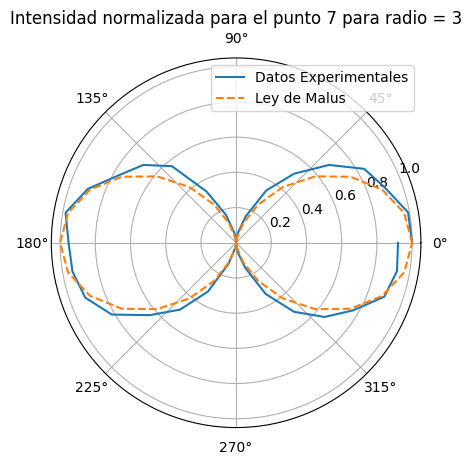

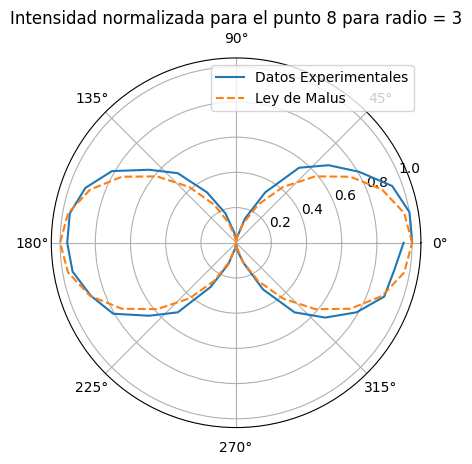

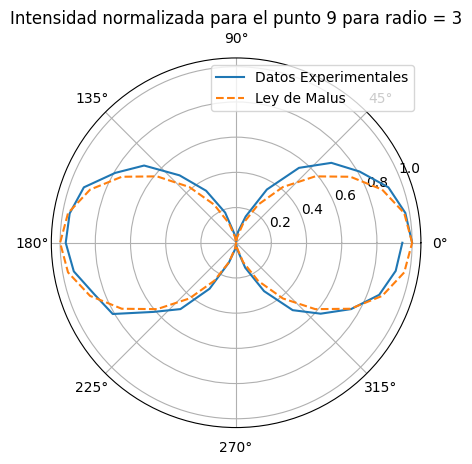

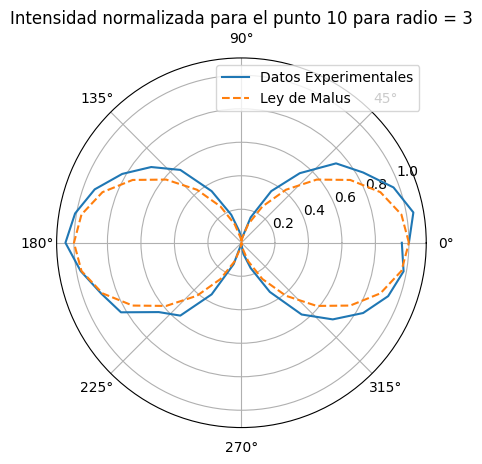

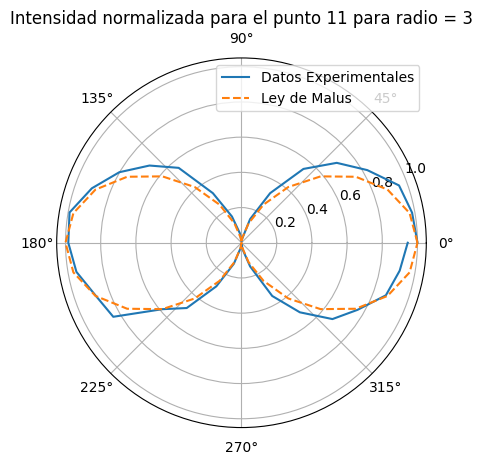

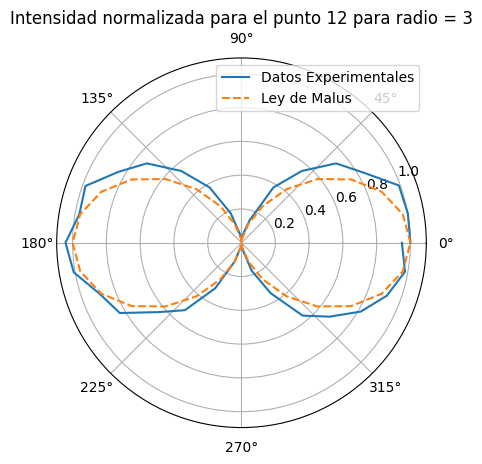

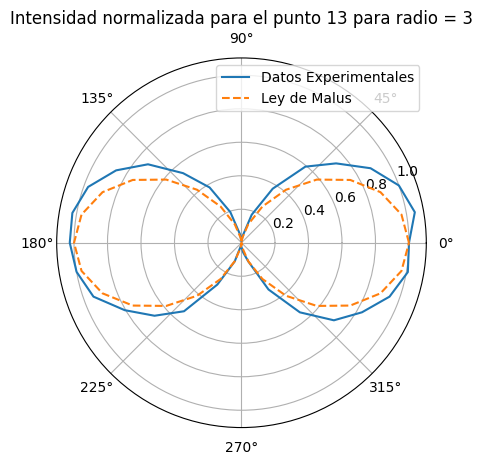

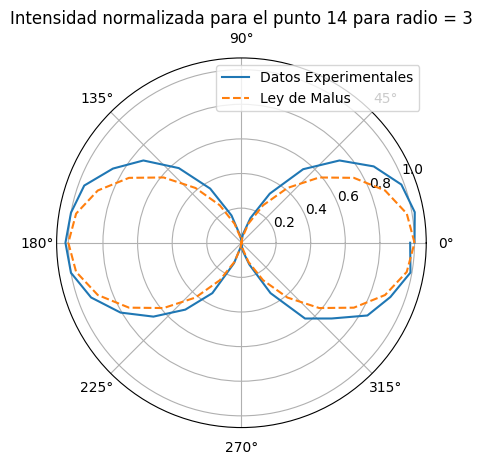

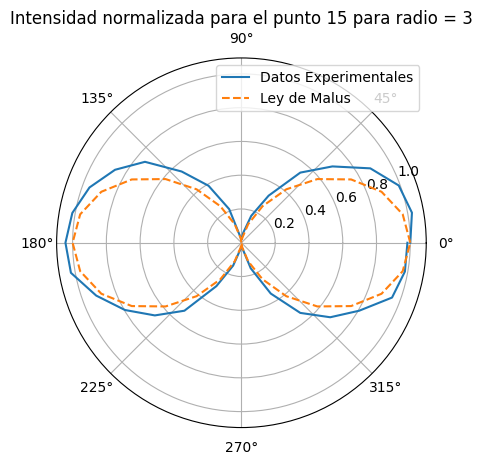

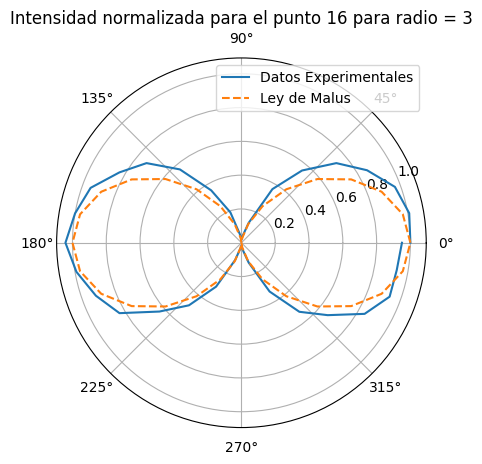

In [25]:
plot_intensidad_por_punto_polar(I_XY_recortado,radio,Nx,Ny,N_fotos)

Se muestra la intensidad promediada en los 16 puntos para cada uno de los 36 ángulos
----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.01 +/- 0.01,
b = 1.003 +/- 0.003

Correlation Matrix: 
[[ 1.    -0.187]
 [-0.187  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


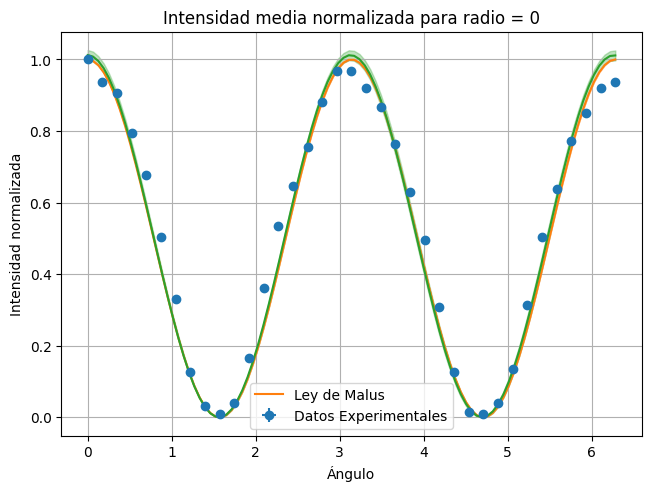

Se muestra la intensidad promediada en los 16 puntos para cada uno de los 36 ángulos
----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.03 +/- 0.01,
b = 1.004 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.186]
 [-0.186  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


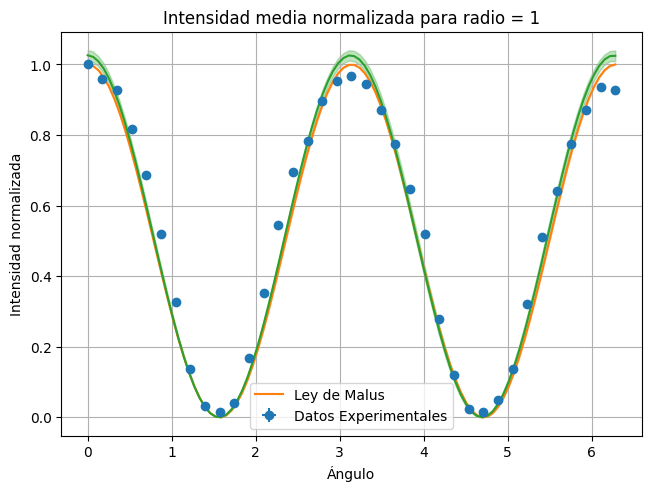

Se muestra la intensidad promediada en los 16 puntos para cada uno de los 36 ángulos
----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.04 +/- 0.01,
b = 1.004 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.185]
 [-0.185  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


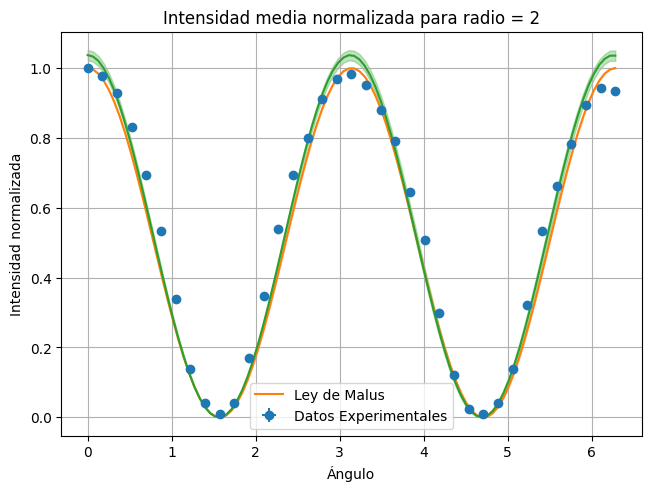

Se muestra la intensidad promediada en los 16 puntos para cada uno de los 36 ángulos
----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
a = 1.04 +/- 0.01,
b = 1.004 +/- 0.004

Correlation Matrix: 
[[ 1.    -0.185]
 [-0.185  1.   ]]

chi2/ndof = 0.00/34

--------------- End Fit Results -----------------


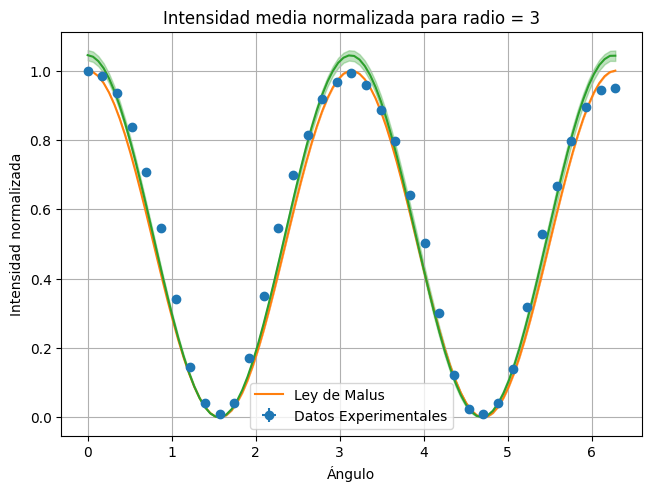

In [14]:
plot_intensidad_promedio_por_radio(I_XY_recortado,[0,1,2,3],Nx,Ny,N_fotos)

Se muestra la intensidad promediada en los 16 puntos para cada uno de los 36 ángulos


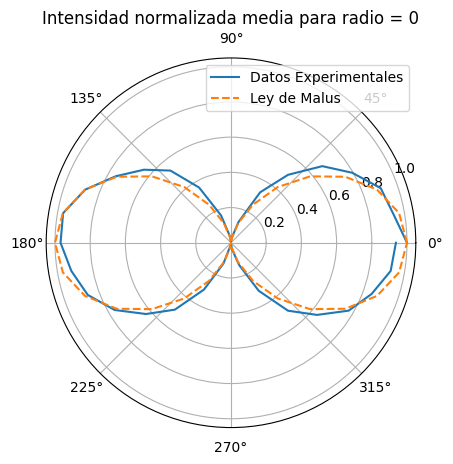

Se muestra la intensidad promediada en los 16 puntos para cada uno de los 36 ángulos


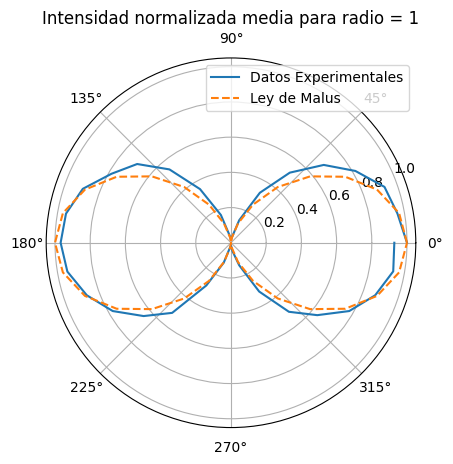

Se muestra la intensidad promediada en los 16 puntos para cada uno de los 36 ángulos


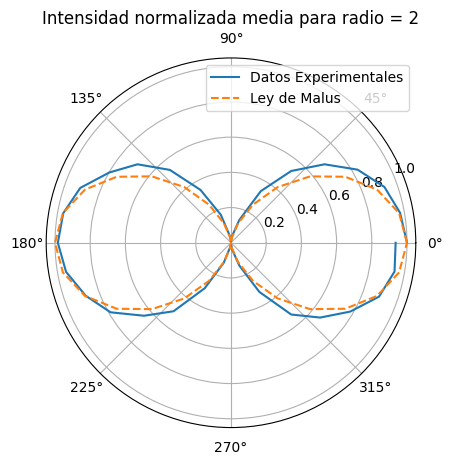

Se muestra la intensidad promediada en los 16 puntos para cada uno de los 36 ángulos


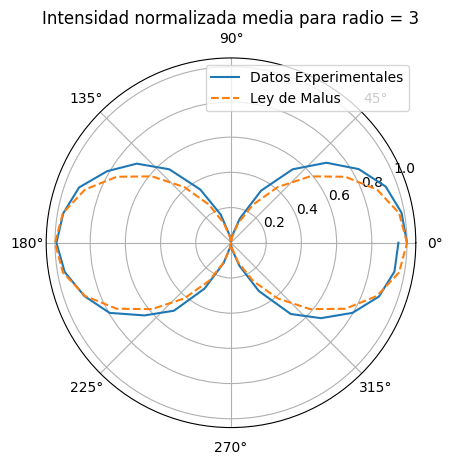

In [17]:
plot_media_polar_por_radio(I_XY_recortado,[0,1,2,3],Nx,Ny,N_fotos)

In [26]:
I_XY_color = I_XY = read_images('Images_ImageAnalysis/c','jpg','color',37)

Imagenes convertidas con éxito a color


In [49]:
I_XY_color_B = [I_XY_color[i][:,:,0] for i in range(len(I_XY_color))]
I_XY_color_G = [I_XY_color[i][:,:,1] for i in range(len(I_XY_color))]
I_XY_color_R = [I_XY_color[i][:,:,2] for i in range(len(I_XY_color))]

Las imagenes se imprimen en color RGB


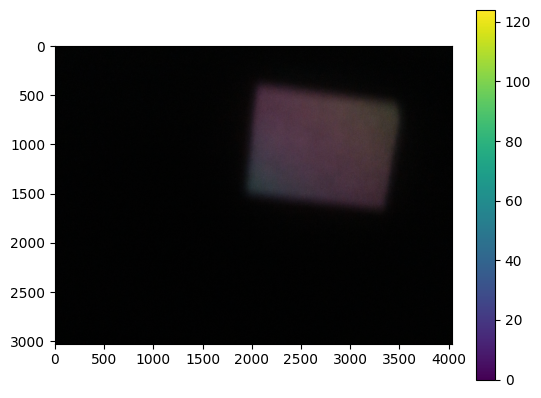

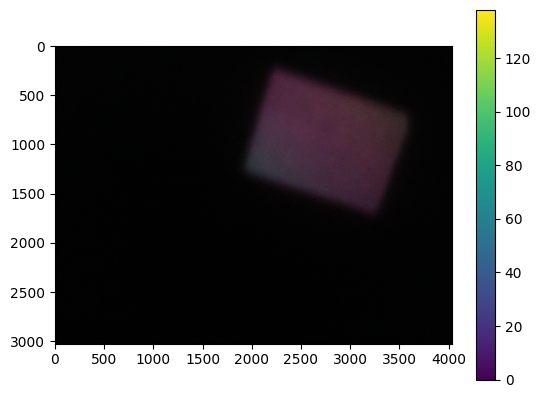

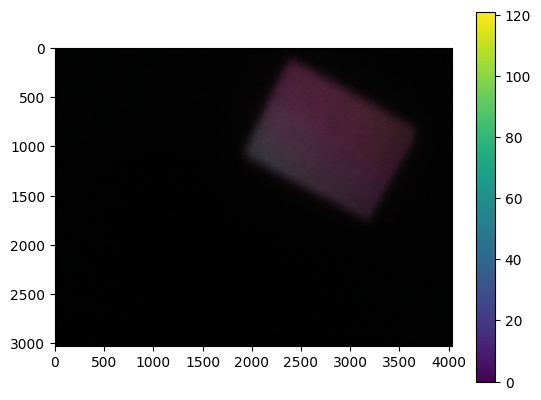

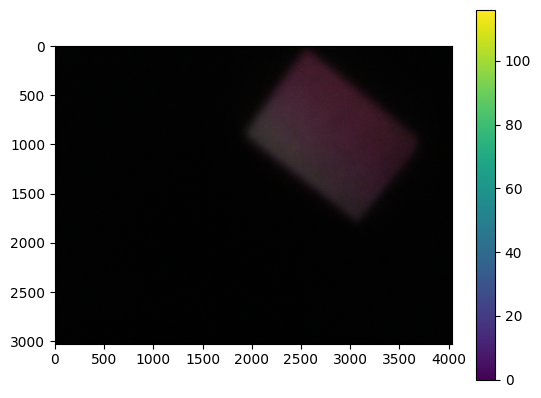

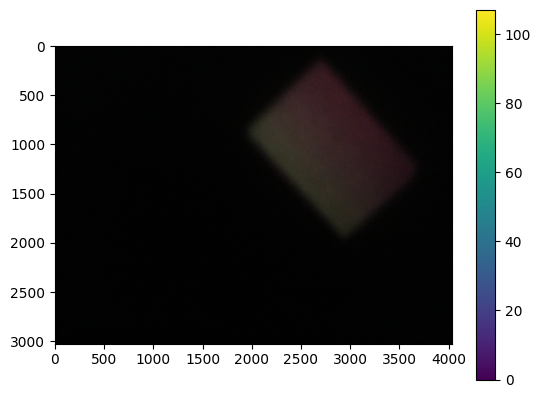

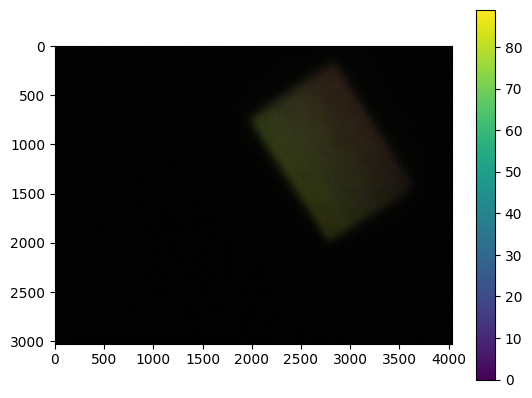

In [47]:
print_images(I_XY_color, 'color', 6)
